In [1]:
%matplotlib inline
'''
this script is meant to use the trained neural network
and automatically move classified new faces to their respective folders
in order to improve the training
'''
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from urllib import urlretrieve
import cPickle as pickle
import os
import gzip

import cv2
import numpy as np
import theano

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum

from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

_image_size = 57
global _labels
_labels = ["Tobi", "Mariam", "Negative"] # human readable labels, insert hose in the load-data function

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: invalid device ordinal)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
net = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 3, _image_size, _image_size),
    # layer conv2d1
    conv2d1_num_filters=64,
    conv2d1_filter_size=(5, 5),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),
    # layer maxpool1
    maxpool1_pool_size=(2, 2),
    # layer conv2d2
    conv2d2_num_filters=64,
    conv2d2_filter_size=(5, 5),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # dropout1
    dropout1_p=0.5,
    # dense
    dense_num_units=361,
    dense_nonlinearity=lasagne.nonlinearities.rectify,
    # dropout2
    dropout2_p=0.5,
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=6,
    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.8,
    max_epochs=300,
    verbose=1,
    )

In [3]:
net.load_weights_from('facerecognet')

/usr/local/lib/python2.7/dist-packages/nolearn/lasagne/base.py:734: UserWarning: The 'load_weights_from' method will be removed in nolearn 0.6. Please use 'load_params_from' instead.
  warn("The 'load_weights_from' method will be removed in nolearn 0.6. "
/usr/local/lib/python2.7/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


Loaded parameters to layer 'conv2d1' (shape 64x3x5x5).
Loaded parameters to layer 'conv2d1' (shape 64).
Loaded parameters to layer 'conv2d2' (shape 64x64x5x5).
Loaded parameters to layer 'conv2d2' (shape 64).
Loaded parameters to layer 'dense' (shape 7744x361).
Loaded parameters to layer 'dense' (shape 361).
Loaded parameters to layer 'output' (shape 361x6).
Loaded parameters to layer 'output' (shape 6).


Got 932 files


Got 793 files


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


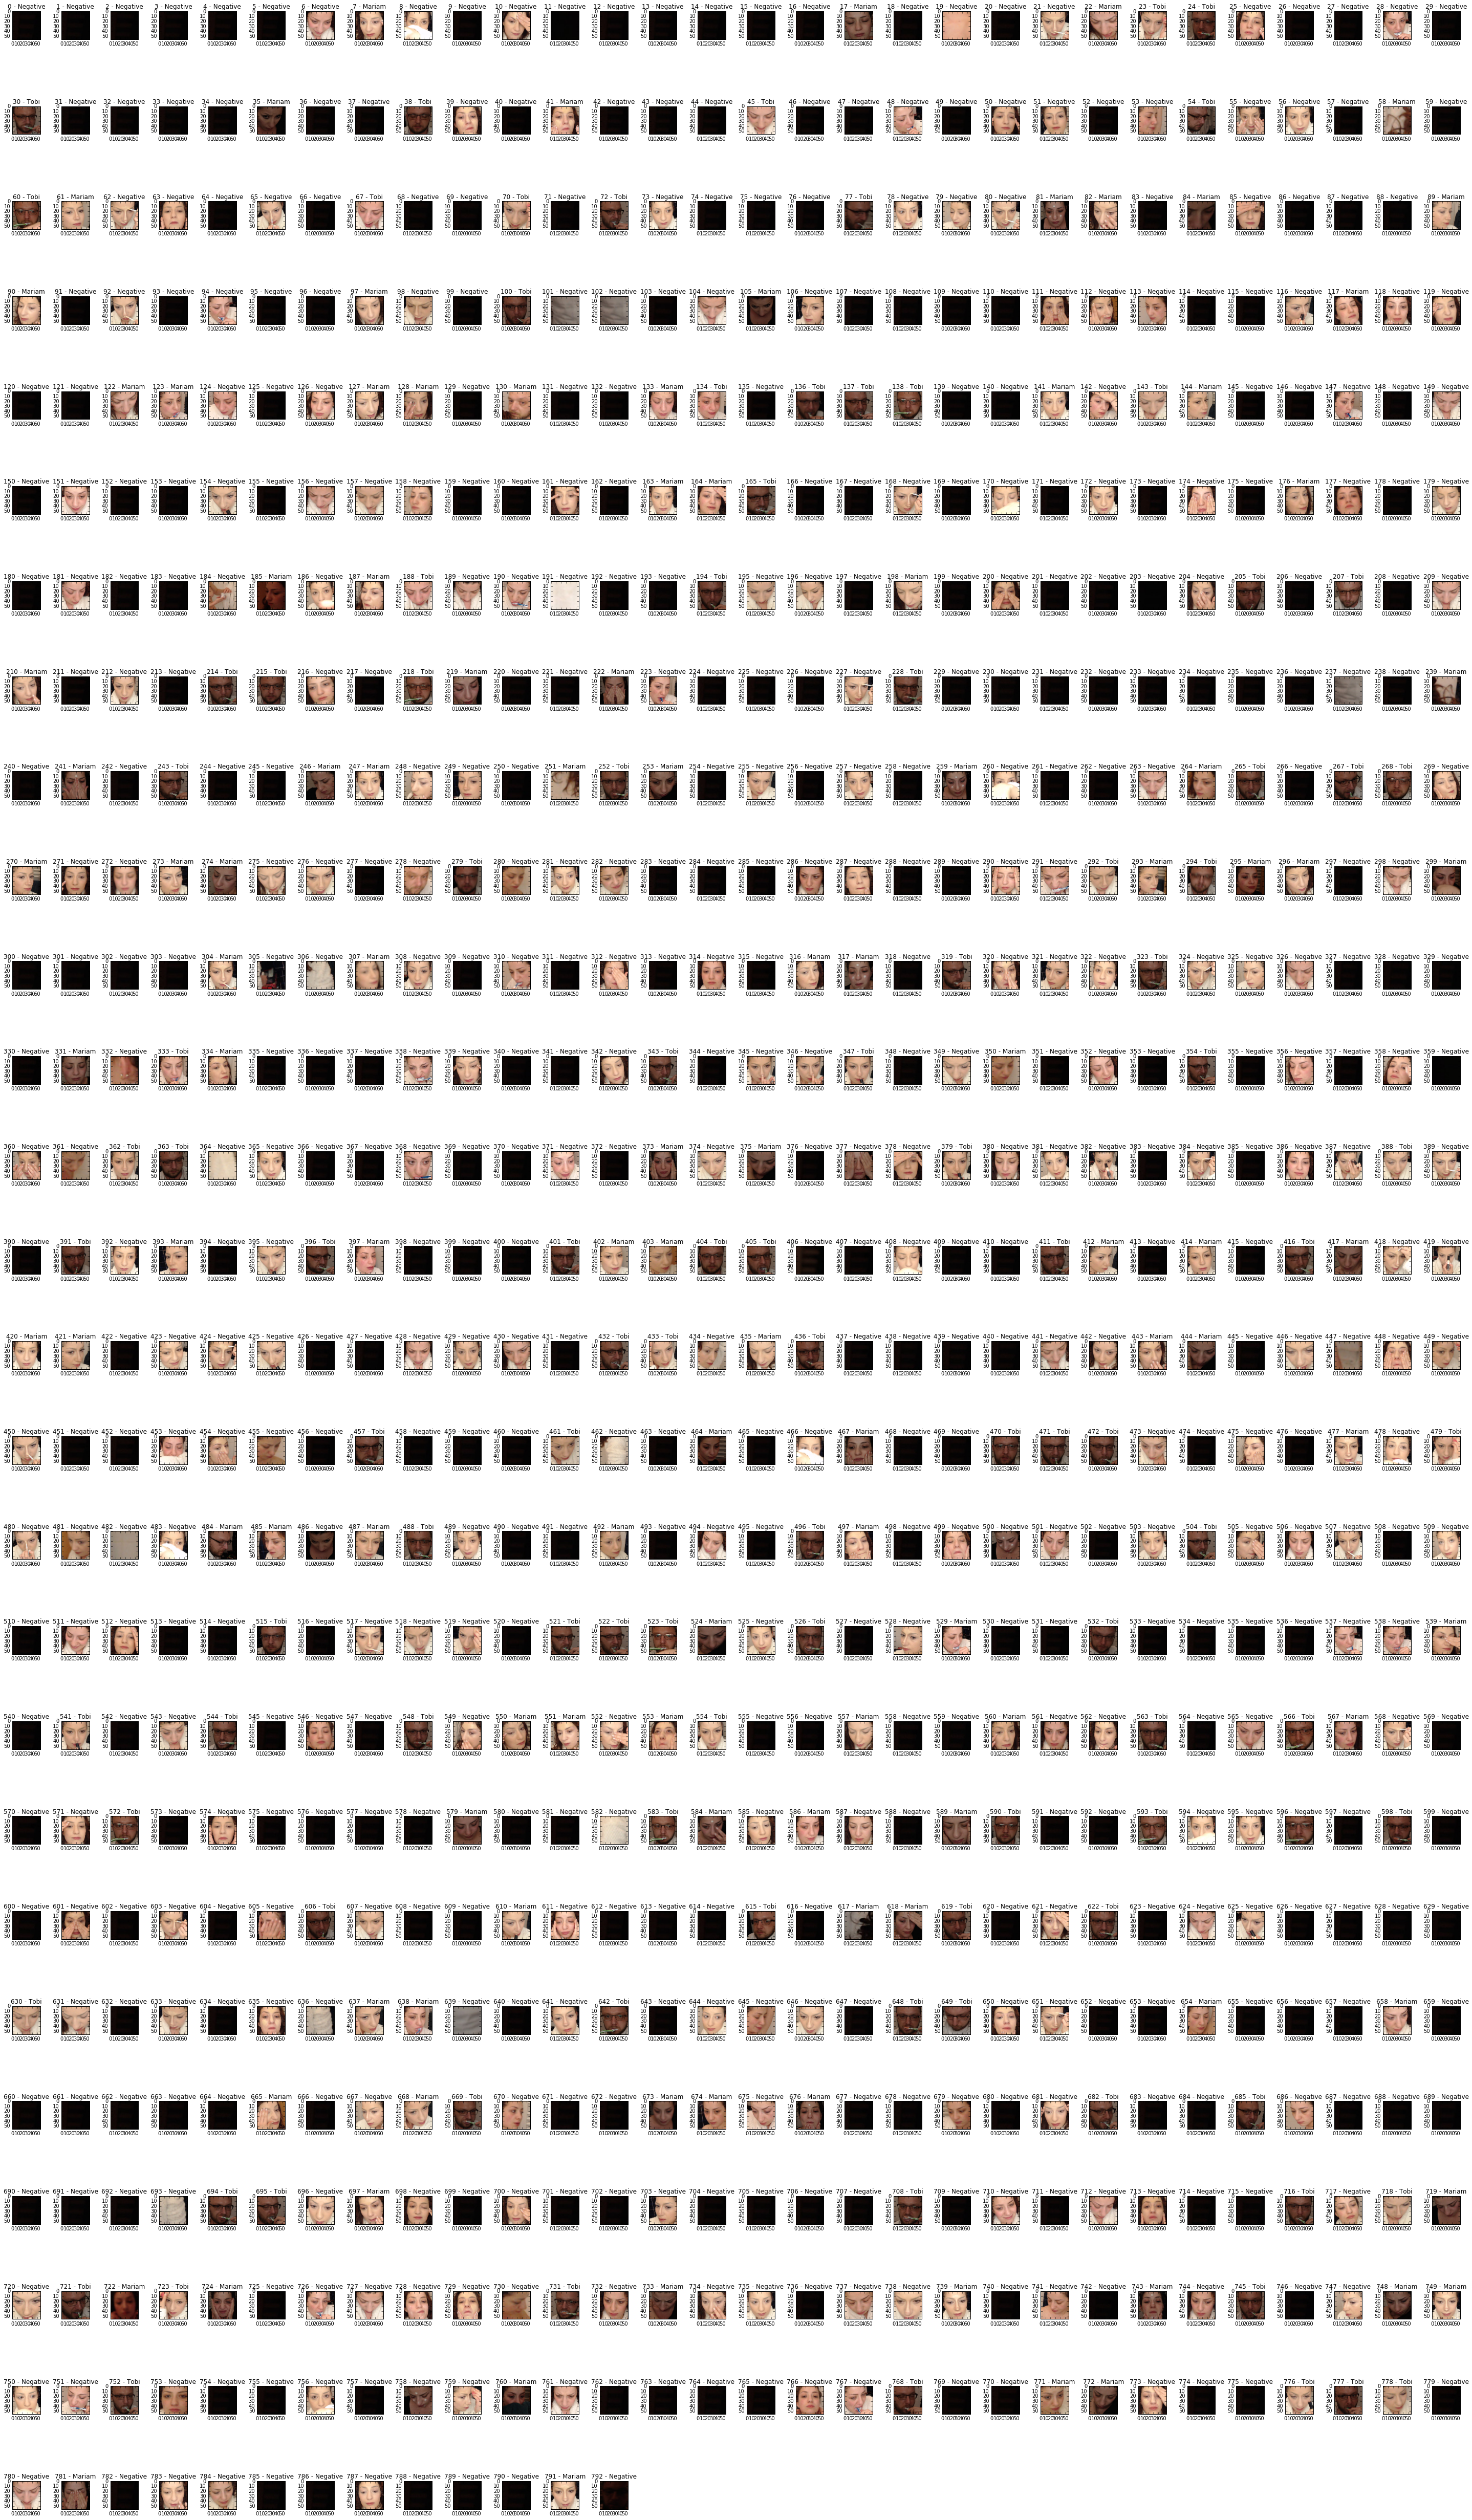

In [6]:
import glob
files = glob.glob("./faces_120/face*.png")
print "Got %d files" % (len(files))

import math
fig = plt.figure(figsize=(40,70))
files = files[:900]
nimages = len(files)
cols = 30
rows = math.ceil(nimages / float(cols))
for i,f in enumerate(files[:nimages]):
    #print "Loading file: ", f    
    fig.add_subplot(rows,cols,i+1)
    img = cv2.resize(cv2.imread(f) / 255., (_image_size,_image_size))
    img = img.transpose(2,0,1).reshape(3, _image_size, _image_size).astype(np.float32) # transform in suited format for NN
    pred = net.predict(np.array([img]))
    #print "Prediction: ", pred
    plt.title("%d - %s" % (i,_labels[pred]))
    plt.imshow(cv2.cvtColor(img.transpose(1,2,0).reshape(_image_size, _image_size,3), cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

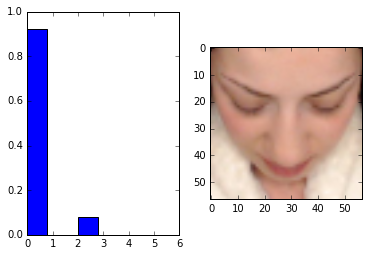

In [7]:
# show details about specific images
dense_layer = layers.get_output(net.layers_['dense'], deterministic=True)
output_layer = layers.get_output(net.layers_['output'], deterministic=True)
input_var = net.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

#instance = X_test[0][None, :, :]
img = cv2.resize(cv2.imread(files[45]) / 255., (_image_size,_image_size))
img = img.transpose(2,0,1).reshape(3, _image_size, _image_size).astype(np.float32) # transform in suited format for NN
instance = np.array([img])
pred = f_output(instance)
N = pred.shape[1]
fig = plt.figure()
fig.add_subplot(121)
plt.bar(range(N), pred.ravel())
fig.add_subplot(122)
plt.imshow(cv2.cvtColor(img.transpose(1,2,0).reshape(_image_size, _image_size,3), cv2.COLOR_BGR2RGB))